In [1]:
import math
import os
import pickle
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import device
from torch.utils.data import DataLoader, Subset
from torchmetrics.classification import MulticlassAccuracy
from torchvision import datasets, utils
from tqdm import tqdm

from efficient_kan.kan import KAN
from kan.KAN_batch import KAN as PyKAN
from kan_convolutional import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from torchkan.KANvolver import KANvolver as kanv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TRAININGSET + TESTSET DEFINITION

In [2]:
dataset = [datasets.MNIST, datasets.CIFAR10][0]
dataset_name = dataset.__name__.lower()
input_size = 28 * 28 if dataset == datasets.MNIST \
    else 3 * 32 * 32 if dataset == datasets.CIFAR10 \
    else -1

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.Normalize((0.5,), (0.5,))
                                ])
# Train set. Here we sort the MNIST by digits and disable data shuffling
train_dataset = dataset(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset) // 1), key=lambda idx: train_dataset.targets[idx])
train_subset = Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)

# MultiTask training sets
train_loader_tasks = []
indices = []
for k in range(5):
    indices.append(list(
        filter(lambda idx: train_dataset.targets[idx] in range(k * 2, k * 2 + 2), range(len(train_dataset)))))
    train_loader_tasks.append(
        DataLoader(Subset(train_dataset, indices[-1]), batch_size=64, shuffle=True))

# Test set
test_dataset = dataset(root='./data', train=False, download=True, transform=transform)
test_subset = Subset(test_dataset, range(len(test_dataset) // 1))
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Trainset visualizer
The following code prints the images of the 5 domain IL scenarios. This way we can clearly see that for the MNIST dataset each task contains a pair of digits (0-1, 2-3, etc.), while for CIFAR10 each task contains a pair of objects (car-airplane, bird-dog, deer-dog, frog-horse and truck-ship).

TASK ID = 0


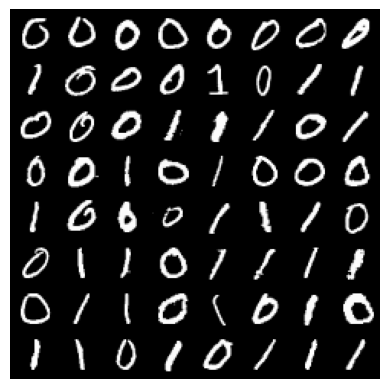

TASK ID = 1


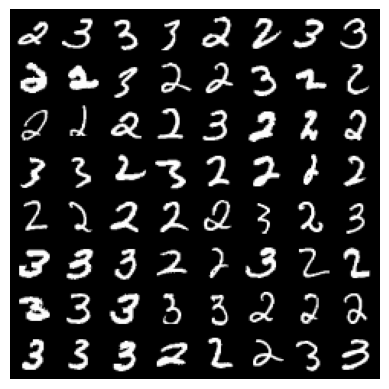

TASK ID = 2


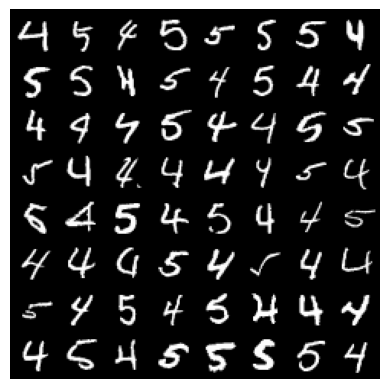

TASK ID = 3


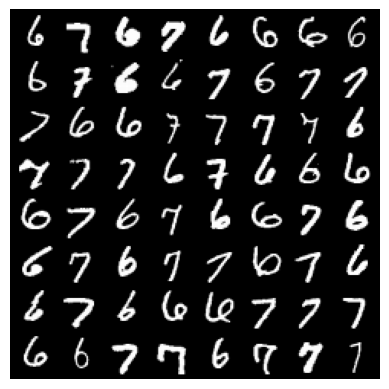

TASK ID = 4


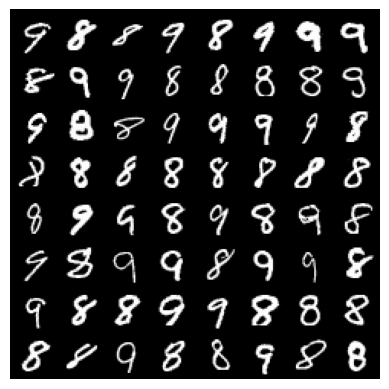

In [29]:
def imshow(img):
    # img = (img / 2 + 0.5).numpy()
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()


def show_images(class_index, num_images=16):
    dataiter = iter(train_loader_tasks[class_index])
    images, labels = next(dataiter)
    imshow(utils.make_grid(images))


for class_index in range(5):
    print(f"TASK ID = {class_index}")
    show_images(class_index)

# ARCHITECTURES DEFINITION
The various Fully Connected and Conv-based architectures employ the log_softmax() function on the logits. This indicates that a NLLLoss loss function should be used instead of Cross Entropy. 

In [7]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None, output_size=10):
        super(MLP, self).__init__()
        self.layers = [input_size, 28 * 28, 256, output_size] if dataset == datasets.MNIST \
            else [input_size, 32 * 32, 512, output_size] if dataset == datasets.CIFAR10 \
            else []
        self.fc1 = nn.Linear(self.layers[0], self.layers[1])
        self.fc2 = nn.Linear(self.layers[1], self.layers[2])
        self.fc3 = nn.Linear(self.layers[2], self.layers[3])
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        # x = (x / 0.5 - 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [22]:
# MLP
class MLP_Normalized(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP_Normalized, self).__init__()
        self.layers = [input_size, 28 * 28, 256, 10] if dataset == datasets.MNIST \
            else [input_size, 32 * 32, 512, 10] if dataset == datasets.CIFAR10 \
            else []
        self.fc1 = nn.Linear(self.layers[0], self.layers[1])
        self.fc2 = nn.Linear(self.layers[1], self.layers[2])
        self.fc3 = nn.Linear(self.layers[2], self.layers[3])
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = x * 2 - 1
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [35]:
# KAN
class Efficient_KAN(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None, output_size=10):
        super(Efficient_KAN, self).__init__()
        self.layers = [input_size, 8, output_size] if dataset == datasets.MNIST \
            else [input_size, 128, output_size] if dataset == datasets.CIFAR10 \
            else []
        self.model = KAN(self.layers).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

In [21]:
class Efficient_KAN_non_Normalized(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(Efficient_KAN_non_Normalized, self).__init__()
        self.layers = [input_size, 64, 10] if dataset == datasets.MNIST \
            else [input_size, 128, 10] if dataset == datasets.CIFAR10 \
            else []
        self.model = KAN(self.layers).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = x * 2 - 1
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

In [15]:
class Py_KAN(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(Py_KAN, self).__init__()
        self.layers = [input_size, 64, 10] if dataset == datasets.MNIST \
            else [input_size, 128, 10] if dataset == datasets.CIFAR10 \
            else []
        self.model = PyKAN(self.layers, device=device).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def train(self, epochs=5, on_epoch_end=None, lr=1, train_loader=None):
        self.model.train(train_loader, test_loader, lr=lr, epochs=epochs, device=device,
                         metrics=MulticlassAccuracy(num_classes=10).to(device), opt="Adam")

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x


In [12]:
# KAN_Convolutional_Layer + MLP
class CKAN_BN(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn1 = nn.BatchNorm2d(5)

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn2 = nn.BatchNorm2d(25)

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [13]:
# KAN_Convolutional_Layer + MLP (without Batch Norm)
class KANC_MLP(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [14]:
# Conv2d + KAN
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # KAN layer
        self.kan1 = KANLinear(
            245,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [15]:
# Conv2d + MLP + (Dropout)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layers = [1, 64 * 7 * 7, 256, 10] if dataset == datasets.MNIST \
            else [3, 64 * 8 * 8, 256, 10] if dataset == datasets.CIFAR10 \
            else []

        self.conv1 = nn.Conv2d(self.layers[0], 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(self.layers[1], self.layers[2])
        self.fc2 = nn.Linear(self.layers[2], self.layers[3])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        #x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout3(x)
        x = self.fc2(x)

        x = F.log_softmax(x, dim=1)
        return x

In [16]:
# KAN_Convolutional_Layer + KAN
class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.kan1 = KANLinear(
            625,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1],
        )

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)

        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [17]:
# Conv2d + MLP
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.layers = [1, 245, 10] if dataset == datasets.MNIST \
            else [3, 320, 10] if dataset == datasets.CIFAR10 \
            else []

        self.conv1 = nn.Conv2d(self.layers[0], 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.layers[1], self.layers[2])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

In [19]:
# KANvolver This works only on MNIST for now. The source code should be adjusted.
class KANvolver(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KANvolver, self).__init__()
        self.model = kanv([10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x)

# TRAIN() AND TEST() FUNCTIONS

In [9]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0, loader=None,
          task_id=None):
    if loader is None:
        loader = train_loader
    criterion = nn.NLLLoss()
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.996)
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        epoch_start = time.time_ns()
        with tqdm(loader) as pbar:
            for images, labels in pbar:
                labels = (labels % 2 if task_id is not None else labels).to(device)
                images = images.to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step(closure=lambda: loss)
                accuracy = (output.argmax(dim=1) == labels).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, loss.item(), epoch_duration, lr, task_id)
        # torch.save(model.state_dict(), f'{checkpoint}_ep{epoch + 1}.pth')

In [10]:
def test(model):
    model.eval()
    criterion = nn.NLLLoss()
    predictions = []
    ground_truths = []
    val_accuracy = 0
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = (labels % 2 if model.layers[-1] == 2 else labels).to(device)
            output = model(images)
            loss = criterion(output, labels)
            predictions.extend(output.argmax(dim=1).to('cpu').numpy())
            ground_truths.extend(labels.to('cpu').numpy())
            val_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
    val_accuracy /= len(test_loader)
    print(f"Accuracy: {val_accuracy}")
    return loss.item(), ground_truths, predictions

# INTRA and INTER DATASET TESTS
This class holds all relevant information about a training + test epoch. All the information needed to compute a confusion matrix is stored in the labels[] and predictions[] lists. Each serialised file takes about 300KiB, so they were added to the gitignore file.

In [24]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, dir=f'results/{dataset_name}/intra/', subdir='') -> list['EpochStat']:
        return sorted([pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))],
                      key=lambda e: e.epoch)

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None, task_id=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.task_id = task_id

    def save(self, dir=f'results/{dataset_name}/intra/'):
        os.makedirs(dir, exist_ok=True)
        pickle.dump(self, open(f'{dir}{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_loss, epoch_duration, lr, task_id):
    test_loss, labels, predictions = test(model)
    stat = EpochStat(model.__class__.__name__, epoch, train_loss, test_loss, labels, predictions, epoch_duration,
                     lr, [], [], task_id)
    stat.save(
        dir=f'results/{dataset_name}/intra/lr_{round(math.log10(lr))}/' if task_id is None else f'results/{dataset_name}/inter/lr_{round(math.log10(lr))}/')

## INTRA DATASET TEST

In [20]:
for lr in [1e-5, 1e-6]:
    models = [Efficient_KAN(), MLP(), Efficient_KAN_non_Normalized(), MLP_Normalized(),
              CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
              KKAN_Convolutional_Network(), SimpleCNN(), KANvolver()]
    print(f'Using lr={lr} ------------------------------------')
    for model in [x.to(device) for x in models[:2]]:
        print(f'Training model={model.__class__.__name__}')
        train(model, f'results/{dataset_name}/intra/{model.__class__.__name__}', epochs=18, start_epoch=0,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr)

NameError: name 'Efficient_KAN_non_Normalized' is not defined

## INTER DATASET TEST

In [ ]:
for epochs, lr in zip([10], [1e-5]):
    models = [MLP(output_size=2), Efficient_KAN(output_size=2),
              CKAN_BN(), KANC_MLP(), NormalConvsKAN(), KKAN_Convolutional_Network(), SimpleCNN(), KANvolver()]
    print(f'Using lr={lr} ------------------------------------')
    for model in [x.to(device) for x in models[:2]]:
        print(f'Training model={model.__class__.__name__}')
        for i, task in enumerate(train_loader_tasks):
            print(f'Training on task {i}')
            train(model, f'results/{dataset_name}/inter/{model.__class__.__name__}', epochs=epochs,
                  start_epoch=i * epochs, optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd,
                  lr=lr, loader=task, task_id=i)

In [16]:
# PyKAN custom training
for lr in [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    kan = Py_KAN()
    test(kan)
    # kan.train(lr=lr, train_loader=train_loader_tasks[0])

Accuracy: 0.15684713375796178
Accuracy: 0.15684713375796178



KeyboardInterrupt



# RESULTS PLOTTING

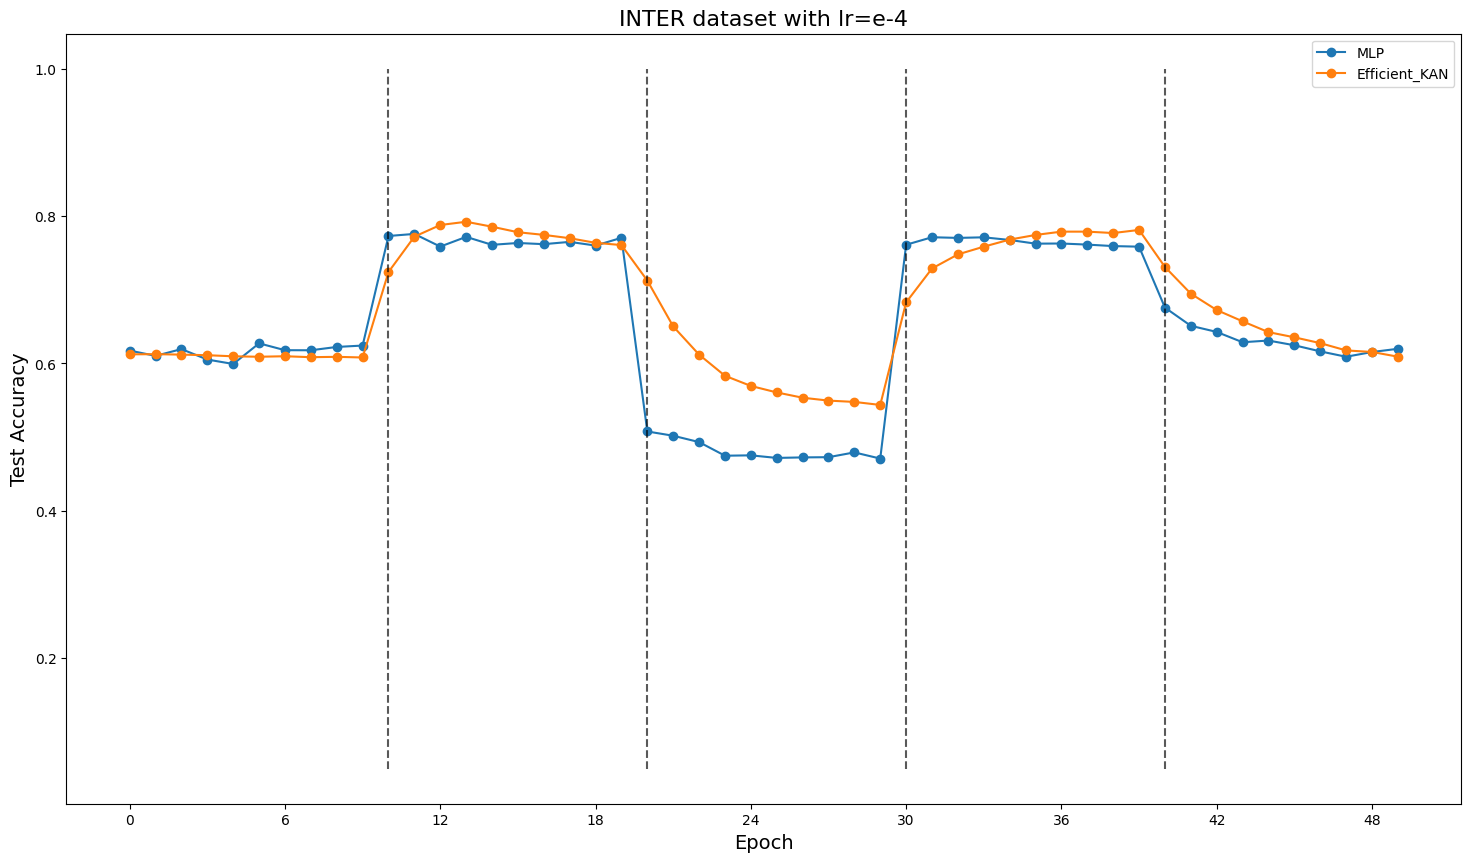

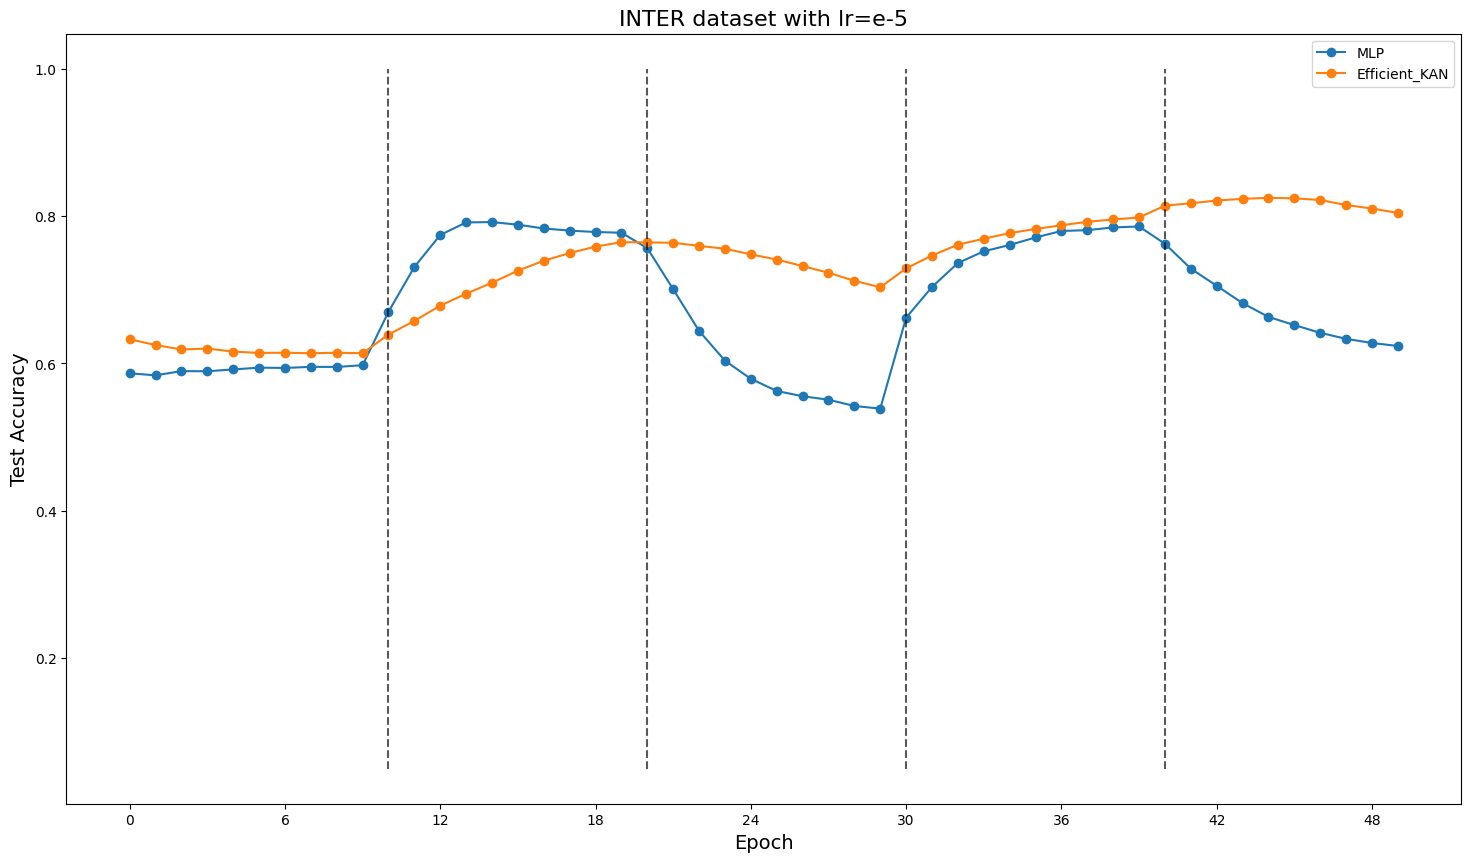

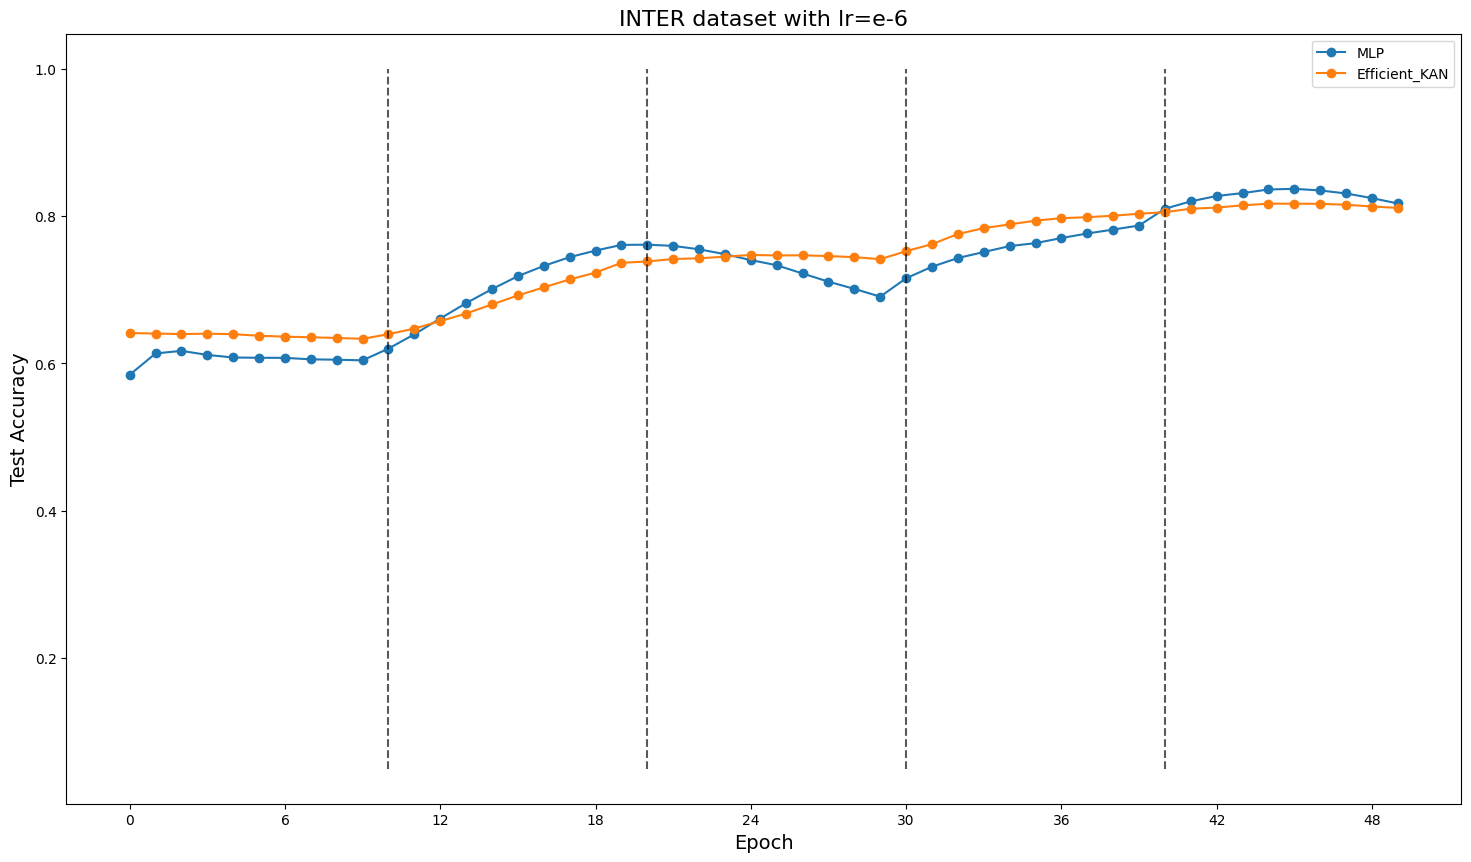

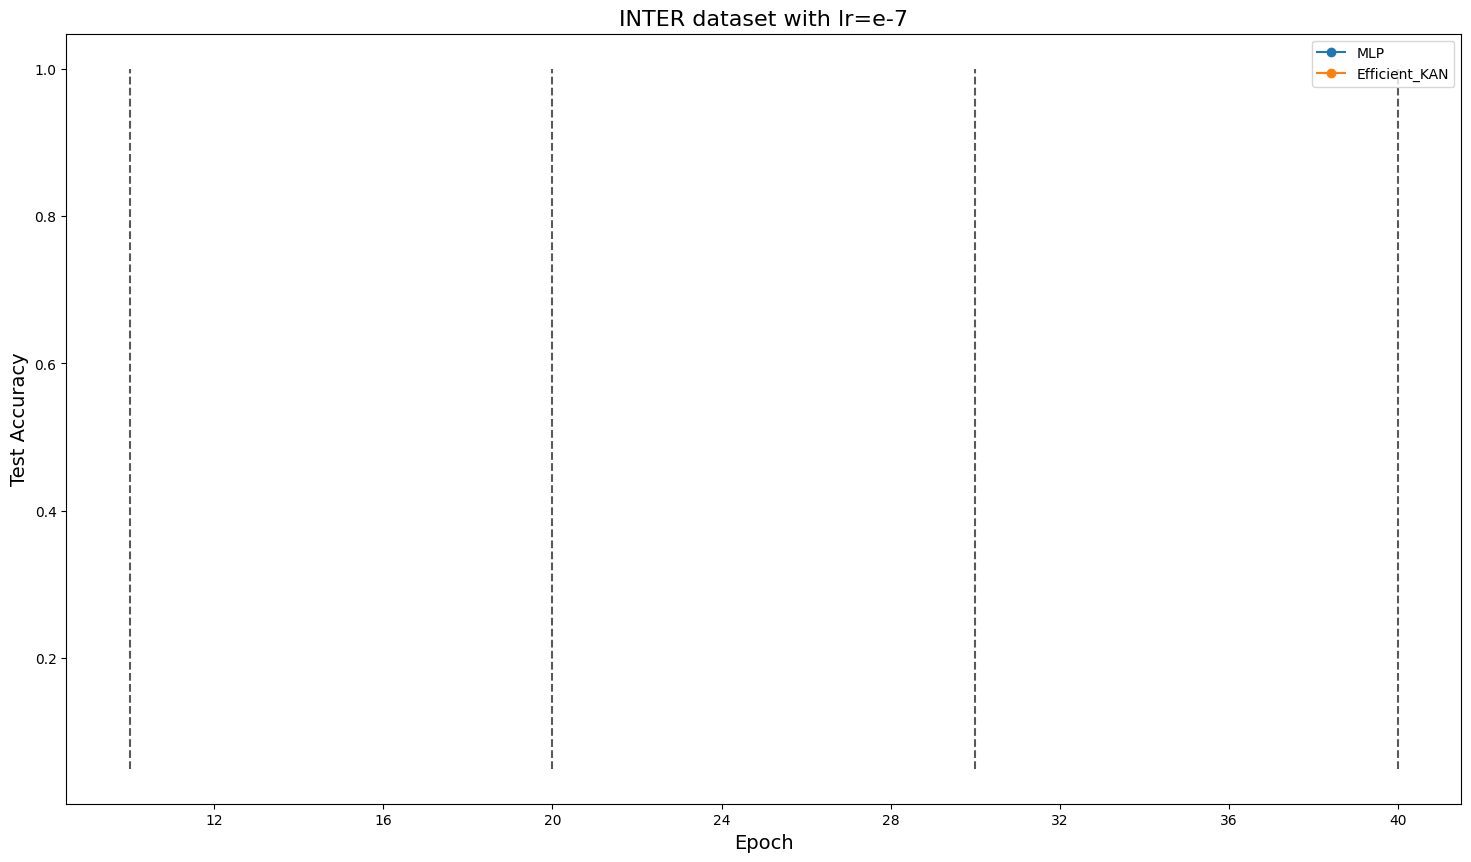

In [37]:
models = [MLP(), Efficient_KAN(), MLP_Normalized(), Efficient_KAN_non_Normalized(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(),
          KKAN_Convolutional_Network(), SimpleCNN(), KANvolver()]
for lr in [1e-4, 1e-5, 1e-6, 1e-7]:
    fig, ax = plt.subplots()
    batches = [
        0,
        5923,
        6742,
        5958,
        6131,
        5842,
        5421,
        5918,
        6265,
        5851,
        # 5949,
    ]
    granularity = 1
    for name in list(map(lambda e: e.__class__.__name__, models[:2])):
        stats = EpochStat.loadModelStats(name, dir=f'results/{dataset_name}/inter/',
                                         subdir=f'lr_{round(math.log10(lr))}/')
        ax.plot(list(map(lambda e: e.get_accuracy(), stats))[:], label=name, marker='o')
        # ax.plot(list(map(lambda e: e.train_accuracies, stats))[0][::granularity], label=name)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_xticks([x // 64 // granularity for x in itertools.accumulate(batches)])
    # ax.set_xticklabels(range(10))
    # plt.vlines(x=[x // 64 // granularity for x in itertools.accumulate(batches)], ymin=0, ymax=1, colors='black',
    #            alpha=0.65, linestyles='dashed')
    # plt.xlabel('Train Digits Batches', fontdict={'fontsize': 14})
    # plt.ylabel('Train batch Loss', fontdict={'fontsize': 14})
    # plt.title('Train batch loss spikes show up when a new digit is submitted', fontdict={'fontsize': 16})
    plt.xlabel('Epoch', fontdict={'fontsize': 14})
    plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
    plt.title(f'INTER dataset with lr=e{round(math.log10(lr))}', fontdict={'fontsize': 16})
    plt.vlines(x=range(0, 5*10, 10)[1:], ymin=0.05, ymax=1, colors='black', alpha=0.65, linestyles='dashed')
    fig.set_size_inches(18, 10)
    plt.show()

## CONFUSION MATRICES PLOTTING

In [ ]:
models = [MLP_non_Normalized(), Efficient_KAN(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN()]
plt.rc('font', size=18)
for lr in [1e-5]:
    for name in list(map(lambda e: e.__class__.__name__, models[:2])):
        stats = EpochStat.loadModelStats(name, dir=f'results/{dataset_name}/intra/',
                                         subdir=f'lr_{round(math.log10(lr))}/')
        for stat in stats[:]:
            cm = confusion_matrix(stat.labels, stat.predictions, labels=range(10))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
            disp.plot()
            fig = disp.ax_.get_figure()
            fig.set_figwidth(8)
            fig.set_figheight(8)
            plt.figtext(0.445, 0.85, f"{name.replace('Efficient_KAN', 'KAN')} Epoch: {stat.epoch}", ha='center',
                        fontsize=22)
            fig.savefig(f'png/{dataset_name}/intra/lr_{round(math.log10(lr))}/{name} ep{stat.epoch}.png')